In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
import itertools

In [256]:
# make a coherent tool to demostrate PCA -> AC -> grouping -> 2 + 1 linregression feature selector

In [257]:
target = pd.read_csv('MC_targetdf')['SalePrice']
#target.shape

In [258]:
Catdf = pd.read_csv('MC_Catdf').drop('Unnamed: 0', axis = 1)
#Catdf.shape

In [259]:
Intdf = pd.read_csv('MC_Intdf').drop(['Unnamed: 0'], axis = 1)
#Intdf.shape

In [496]:
class ClassRegressor:


#goal: build a class to smoothly apply PCA -> Classifier -> grouped LR onto df that have already been separated into - 
#continuous variables, Categorical variables that have been encoded, and the target 
  
    def __init__(self, Int, Cat):
        self.X = Int
        self.Cat = Cat

#Cat pipes takes in: number of PCA dimension, clustering connection, and number of clusters 
    def FitPipe(self, n_PCA_dims, knn, n_clusters):
        pca = PCA(n_components = n_PCA_dims)
        pca_out = pca.fit_transform(self.Cat) #create PCA transformed 
        connectivity = kneighbors_graph(pca_out, n_neighbors = knn, include_self=False)
        AGroup = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward', connectivity = connectivity)
        AGroup.fit(pca_out)
        self.Clusters = AGroup.labels_
        self.n_clusters = n_clusters
    
#spit out PCA coords just for graphin purposes    
    def pca_coords(self, n_PCA_dims):
        pca = PCA(n_components = n_PCA_dims)
        return(pca.fit_transform(self.Cat))
    
#attach groups to Cont df. split and get fit and score for each group    
    def FitLin(self, target):
        
        groups = list(set(self.Clusters))
        newX = deepcopy(self.X)
        newX['group'] = self.Clusters
        t2 = pd.DataFrame(target)
        t2['group'] = self.Clusters
        data = dict()
        y = dict()
        for n in range(0, self.n_clusters):
            data[n] = newX[newX.group == n].drop('group', axis = 1)
            y[n] = t2[t2.group == n].drop('group', axis = 1)
        
        columns = self.X.columns
        combos = list(itertools.product(columns, columns))
        combos = [list(combo) for combo in combos] 
        markers = [(combo[0] + ' : ' + combo[1]) for combo in combos]
        
        #fit and score 
        scores = dict()
        model = dict()
        max_score = dict()
        lin = dict()
        #fitting lin regression for every permutation of feature pairs
        # sloppy and slow but it works for now
        
        for n in range(0, self.n_clusters):
            lin[n] = LinearRegression()
            model[n] = [lin[n].fit(data[n][combo], y[n]) for combo in combos]
            scores[n] = pd.DataFrame([lin[n].fit(data[n][combo], y[n]).score(data[n][combo], y[n]) for combo in combos])
            scores[n]['combo'] = markers
            scores[n].columns = ['score', 'combo']
            max_score[n] = scores[n].sort_values('score', ascending = False).iloc[0]
        return(max_score)
        
        
        
            
        
        
            
           
        
        
    

In [497]:
test = ClassRegressor(Intdf, Catdf)

In [498]:
test.X.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [499]:
test.FitPipe(3, 20, 6)
test_groups = test.Clusters

In [500]:
test_pca = test.pca_coords(3)


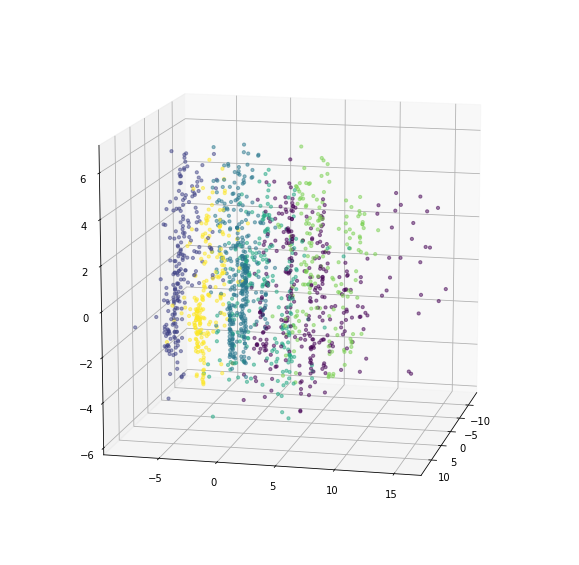

In [501]:
plot_3d(test_pca, test_groups, 13, 13)

In [502]:
test.FitLin(target)

{0: score                    0.79519
 combo    OverallQual : GrLivArea
 Name: 84, dtype: object, 1: score                    0.764286
 combo    OverallQual : GarageArea
 Name: 95, dtype: object, 2: score                    0.682197
 combo    OverallQual : GarageCars
 Name: 94, dtype: object, 3: score                 0.735683
 combo    GrLivArea : YearBuilt
 Name: 494, dtype: object, 4: score                   0.62534
 combo    OverallQual : 1stFlrSF
 Name: 81, dtype: object, 5: score                    0.859766
 combo    GarageCars : OverallQual
 Name: 842, dtype: object}

In [369]:
lin[2].fit(Intdf, target).score(Intdf, target)

0.86548217162434238

# Tools for making 3d plots

In [98]:
def plot_3d(coords, color, x_rot = 15, y_rot = 30):
    fig = plt.figure(figsize = [10,10])
    color = test_groups
    

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=color, s=10, alpha = 0.5)
    plt.viridis()


    ax.view_init(x_rot, y_rot) # change these params to rotate cube
    plt.show()